In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random

In [1]:
def Boltzmann(z, temp):
    '''
    temp: temperature
    z: linear appximation for z
    '''
    z_max = np.max(z, axis=0, keepdims=True)
    e_z = np.exp( (z - z_max) / temp)
    return e_z / e_z.sum(axis=0)

In [30]:
class Actor:
    def __init__(self, env, gamma, num_tiles, bins):
      np.random.seed(100)
      self.state_num = env.observation_space.shape[0]
      self.action_num = env.action_space.n
      self.w = np.random.uniform(-0.001, 0.001, (self.state_num*bins*num_tiles, self.action_num))
      self.gamma = gamma
    
    def policy(self, state, temp):
      z = np.dot(state, self.w)
      probs = Boltzmann(z, temp)
      highest_prob_action = np.random.choice(range(0, self.action_num), p = probs)
      return highest_prob_action, probs[highest_prob_action]

    def gradient_update(self, action, grad):
      self.w[:, action] += grad
      self.w[:, int(not action)] -= grad

class Critic:
    def __init__(self, env, num_tiles,bins):
      np.random.seed(100)
      self.state_num = env.observation_space.shape[0]
      self.w = np.random.uniform(-0.001, 0.001, self.state_num*bins*num_tiles)
    
    def apply_weight(self, state):
      #print(state)
      return np.dot(state, self.w)

    def update_weight(self, gradient):
      self.w += gradient


def Actor_Critic(env, tile, alpha, temp, num_tiles ,bins, gamma = 0.99):
    #print(temp)
    trial_reward = []
    for j in range(trials):
        Actor_imp = Actor(env, gamma, num_tiles, bins)
        Critic_imp = Critic(env, num_tiles, bins)
        tiling = tile
        tile_grids = tiling.create_tilings()
        rewards = []

        for i in range(episodes):
            reward_ep = 0
            s = env.reset()
            state_encoding = tiling.discretize(s, tile_grids)
            #print(len(state_encoding))
            
            done = False
            while not done:
                
                action, p = Actor_imp.policy(state_encoding, temp[i])
                v_i = Critic_imp.apply_weight(state_encoding)
                
                s, reward, done, _ = env.step(action)
                next_state = tiling.discretize(s, tile_grids)
                v_n = Critic_imp.apply_weight(next_state)

                delta = reward + gamma * v_n - v_i
                gradient = alpha * delta * state_encoding * p * (1 - p)
                Actor_imp.gradient_update(action, gradient)

                critic_grad = alpha * delta * state_encoding
                Critic_imp.update_weight(critic_grad)
                state_encoding = next_state
                
                reward_ep += reward
            rewards.append(reward_ep)
            #print(rewards)
        trial_reward.append(rewards)

    return trial_reward



class tilecoding:
  def __init__(self, env, num_tile, bins):
    self.env = env
    self.obs_dim = env.observation_space.shape[0]
    self.bins = bins
    self.num_tile = num_tile
    self.numTiles = (self.bins**self.obs_dim) * self.num_tile


  def tiles_grid(self, offset_pos):
    min_pos, min_vel, min_angle, min_v_angle = self.env.observation_space.low
    max_pos, max_vel, max_angle, max_v_angle = self.env.observation_space.high
    bins = self.bins

    pos_grid =  np.linspace(min_pos, max_pos, bins )[1:-1] +  offset_pos[0]#np.concatenate((np.array([min_pos]), np.linspace(-2, 2, bins)[0:-1], np.array([max_pos])))
    angle_grid = np.linspace(min_angle, max_angle, bins )[1:-1] + + offset_pos[2] #np.concatenate((np.array([min_angle]), np.linspace(-0.3, 0.3, bins)[0:-1], np.array([max_angle])))
    vel_grid = np.concatenate((np.array([min_vel]), np.linspace(-5, 5, bins)[2:-2], np.array([max_vel])))+ offset_pos[1]
    angle_vel_grid = np.concatenate((np.array([-9999]), np.linspace(-5, 5, bins)[2:-2], np.array([9999]))) + + offset_pos[3]
    grid = [pos_grid, vel_grid, angle_grid, angle_vel_grid ]
    return grid #np.array(grid).flatten()
  
  def create_tilings(self):
    high = np.array([2.5, 5, 0.42, 5])
    low = np.array([-2.5, -5, -0.42, -5])
    offset_pos = (high - low)/(self.num_tile*self.bins)
    n = self.num_tile // 2
    num = -n*offset_pos
    #print(num)
    tiling_specs = [-n*offset_pos]
    for i in range(self.num_tile - 1):
      num += offset_pos
      #print(num)
      tiling_specs.append(num)

    
    #tiling_specs = [-offset_pos, tuple([0.0]*self.env.observation_space.shape[0]), offset_pos]
    #print([print(offsets) for offsets in tiling_specs])
    return [self.tiles_grid(offsets) for offsets in tiling_specs]

  def discretize(self, obs, tile_grid):
    encode = []
    for grids in tile_grid:
      #tile_grid = np.array(tile_grid).reshape(self.obs_dim, -1)
      position_tuple = tuple(int(np.digitize(state, grid)) for state, grid in zip(obs, grids))
      #print(position_tuple)
      array = []
      for i in range(self.obs_dim):
        state = [0]*self.bins
        state[position_tuple[i] - 1] = 1
        array.append(state)
      encode.append(array)
    return np.array(encode).flatten()
  
  
class tilecoding_Mountain:
  def __init__(self, env, num_tile, bins):
    self.env = env
    self.obs_dim = env.observation_space.shape[0]
    self.bins = bins
    self.num_tile = num_tile
    #bins = tuple([bins]*env.observation_space.shape[0])
    self.numTiles = (self.bins**self.obs_dim) * self.num_tile


  def tiles_grid(self, offset_pos):
    #print(offset_pos)
    min_pos, min_vel  = self.env.observation_space.low
    max_pos, max_vel = self.env.observation_space.high
    bins = self.bins

    pos_grid =  np.linspace(min_pos, max_pos, bins + 1)[1:-1] + offset_pos[0]
    vel_grid = np.linspace(min_vel, max_vel, bins + 1)[1:-1] + offset_pos[1]

    grid = [pos_grid, vel_grid]
    return grid #np.array(grid).flatten()
  
  def create_tilings(self):
    offset_pos = (self.env.observation_space.high - self.env.observation_space.low)/(self.num_tile*self.bins)
    n = self.num_tile // 2
    num = -n*offset_pos
    tiling_specs = [-n*offset_pos]
    for i in range(self.num_tile - 1):
      num += offset_pos
      tiling_specs.append(num)

    
    #tiling_specs = [-offset_pos, tuple([0.0]*self.env.observation_space.shape[0]), offset_pos]
    #print(tiling_specs)
    return [self.tiles_grid(offsets) for offsets in tiling_specs]

  def discretize(self, obs, tile_grid):
    encode = []
    for grids in tile_grid:
      #tile_grid = np.array(tile_grid).reshape(self.obs_dim, -1)
      position_tuple = tuple(int(np.digitize(state, grid)) for state, grid in zip(obs, grids))
      #print(position_tuple)
      array = []
      for i in range(self.obs_dim):
        state = [0]*self.bins
        state[position_tuple[i] - 1] = 1
        array.append(state)
      encode.append(array)
    #print(np.array(encode).flatten())
    return np.array(encode).flatten()#np.array(array_160d).reshape(-1, 4)



In [9]:
env = gym.make("MountainCar-v0")
a = tilecoding_Mountain(env, 3, 5)
F = a.create_tilings()
a.discretize((0.1, 0.01), F)

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

In [88]:
env = gym.make("CartPole-v1")
obs = env.reset()

#define the parameters
temp = [5, 1]
bins = 10
num_tiles = 2
alpha = [1/8, 1/4]
trials = 50
gamma = 0.99
episodes = 1000


In [89]:
CP_AC_return = []
learning_return = []
for a in range(len(alpha)):
  temp = np.ones(episodes)*temp[0]
  avg_return = Actor_Critic(env, tilecoding(env, num_tiles, bins), alpha[a], temp, num_tiles, bins)
  learning_return.append(avg_return)

CP_AC_return.append(learning_return)

change_T_return = []
for a in range(len(alpha)):
  temperature = np.linspace(5, 4, episodes)
  avg_return = Actor_Critic(env, tilecoding(env, num_tiles, bins), alpha[a], temperature, num_tiles, bins)
  change_T_return.append(avg_return)
  

CP_AC_return.append(change_T_return)

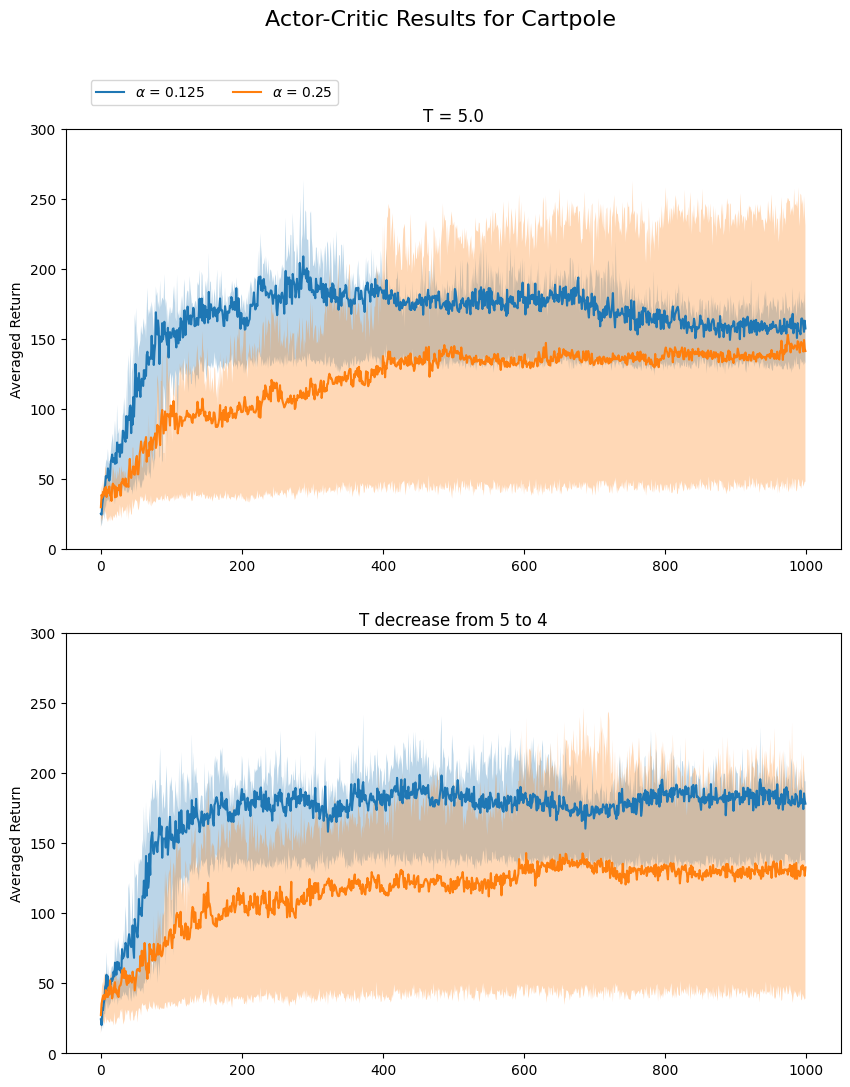

In [92]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

#print(learning_return[0])

plt.rcParams["figure.figsize"]=10,5

for i, learning in enumerate(CP_AC_return):

  for j, alpha_data in enumerate(learning):
    ar_1_mean = np.mean(alpha_data, axis = 0)
    par_1_75, par_1_25 = np.percentile(alpha_data, [75, 25], axis = 0)
    if i == 0:
      axs[i].plot(range(episodes), ar_1_mean, label = f'${{\\alpha}}$ = {alpha[j]}')
      axs[i].set_title(f'T = {temp[i]}')
    else:
      axs[i].plot(range(episodes), ar_1_mean)
      axs[i].set_title(f'T decrease from 5 to 4')
    axs[i].fill_between(range(episodes), par_1_25, par_1_75, alpha=0.3)

plt.setp(axs, ylim=[0, 300], ylabel = 'Averaged Return')
fig.suptitle('Actor-Critic Results for Cartpole', fontsize = 16)

fig.legend(bbox_to_anchor=(0.15, 0.9, 1., .102), loc='lower left',
                      ncol=3, borderaxespad=0.)

In [140]:
env = gym.make("MountainCar-v0")
env._max_episode_steps = 500
obs = env.reset()

#define the parameters
temp = [30, 1]
bins = 10
num_tiles = 2
alpha = [1/16, 1/8]
trials = 50
gamma = 0.99
episodes = 1000


In [141]:
MC_AC_return = []
learning_return = []
for a in range(len(alpha)):
  temp = np.ones(episodes)*temp[0]
  avg_return = Actor_Critic(env, tilecoding_Mountain(env, num_tiles, bins), alpha[a], temp, num_tiles, bins)
  learning_return.append(avg_return)

MC_AC_return.append(learning_return)

change_T_return = []
for a in range(len(alpha)):
  temperature = np.linspace(30, 25, episodes)
  #print(temperature)
  avg_return = Actor_Critic(env, tilecoding_Mountain(env,num_tiles, bins), alpha[a], temperature, num_tiles, bins)
  change_T_return.append(avg_return)
  

MC_AC_return.append(change_T_return)



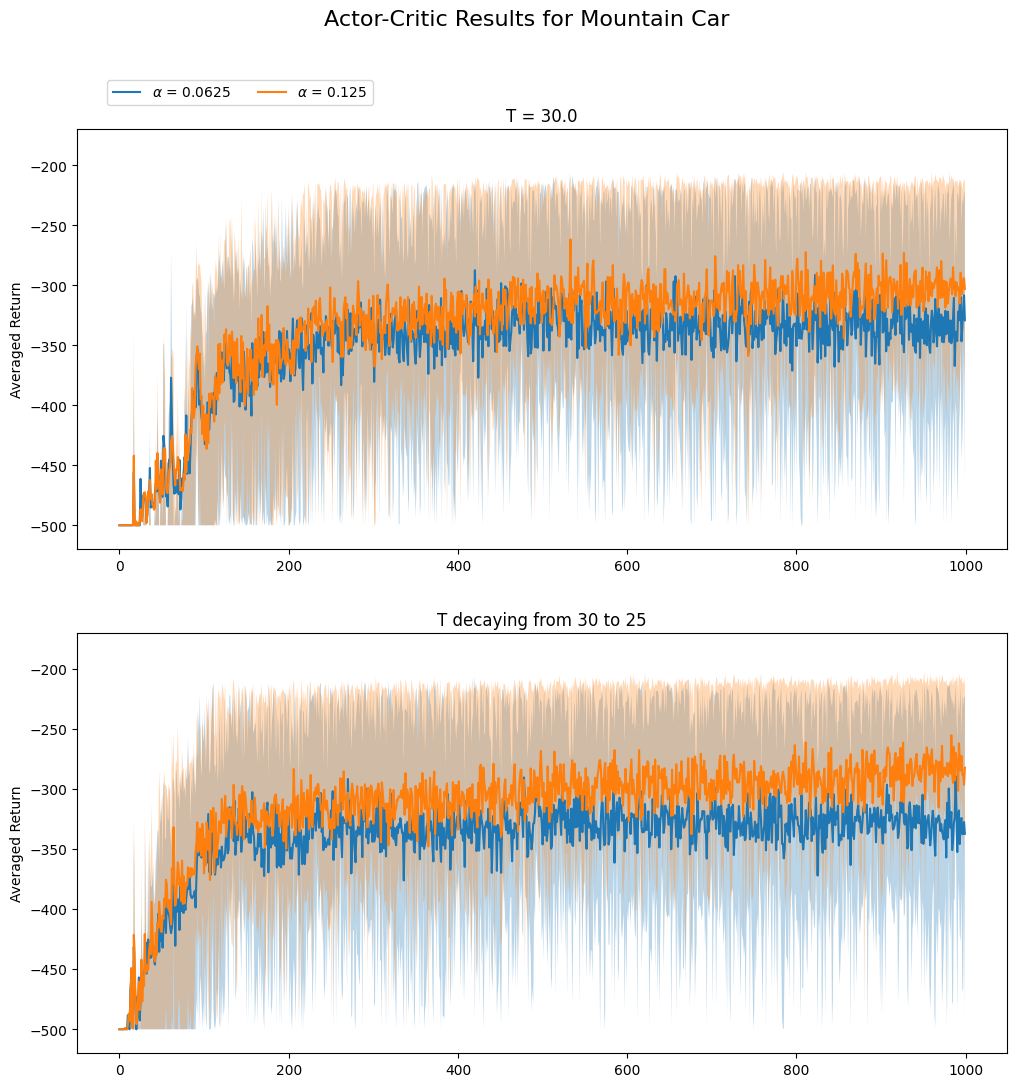

In [145]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

#print(learning_return[0])

plt.rcParams["figure.figsize"]=10,5

for i, learning in enumerate(MC_AC_return):
  par_1_mean = np.mean(learning[0], axis = 0)
  par_1_75, par_1_25 = np.percentile(learning[0], [75, 25], axis = 0)
  axs[0].plot(range(episodes), par_1_mean, label = f'${{\\alpha}}$ = {alpha[i]}')
  axs[0].fill_between(range(episodes), par_1_25, par_1_75, alpha=0.3)
  axs[0].set_title(f'T = {temp[0]}')

  par_2_mean = np.mean(learning[1], axis = 0)
  par_2_75, par_2_25 = np.percentile(learning[1], [75, 25], axis = 0)
  axs[1].plot(range(episodes), par_2_mean)
  axs[1].fill_between(range(episodes), par_2_25, par_2_75, alpha=0.3)
  axs[1].set_title(f'T decaying from 30 to 25')

plt.setp(axs, ylim=[-520, -170], ylabel = 'Averaged Return')
fig.suptitle('Actor-Critic Results for Mountain Car', fontsize = 16)

fig.legend(bbox_to_anchor=(0.15, 0.9, 1., .102), loc='lower left', ncol=2, borderaxespad=0.)